In [21]:
import os
import pandas as pd

emotion_dict = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

def parse_audio_files(base_dir, modality_label):
    data = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".wav"):
                parts = file.split("-")
                if len(parts) != 7:
                    continue  # skip malformed files
                emotion_code = parts[2]
                actor_id = int(parts[-1].split(".")[0])
                emotion = emotion_dict.get(emotion_code)
                file_path = os.path.join(root, file)
                data.append([file_path, emotion, actor_id, modality_label])
    return data

speech_data = parse_audio_files("/home/mishka-singla/Downloads/Audio_Speech_Actors_01-24", "speech")
song_data = parse_audio_files("/home/mishka-singla/Downloads/Audio_Song_Actors_01-24", "song")

# Combine them
df = pd.DataFrame(speech_data + song_data, columns=["path", "emotion", "actor", "modality"])

df.to_csv("ravdess_metadata.csv", index=False)

# Summary check
print("Total rows:", len(df))
print("Modality distribution:\n", df['modality'].value_counts())
print("Actors per modality:\n", df.groupby('modality')['actor'].nunique())


Total rows: 2452
Modality distribution:
 modality
speech    1440
song      1012
Name: count, dtype: int64
Actors per modality:
 modality
song      23
speech    24
Name: actor, dtype: int64


In [22]:
print(df.head())
print(df['emotion'].value_counts())


                                                path    emotion  actor  \
0  /home/mishka-singla/Downloads/Audio_Speech_Act...    fearful     24   
1  /home/mishka-singla/Downloads/Audio_Speech_Act...      happy     24   
2  /home/mishka-singla/Downloads/Audio_Speech_Act...    disgust     24   
3  /home/mishka-singla/Downloads/Audio_Speech_Act...  surprised     24   
4  /home/mishka-singla/Downloads/Audio_Speech_Act...       calm     24   

  modality  
0   speech  
1   speech  
2   speech  
3   speech  
4   speech  
emotion
fearful      376
happy        376
angry        376
calm         376
sad          376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64


In [23]:
# 1. Import Required Libraries

import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, 
                                     BatchNormalization, Reshape, Bidirectional, 
                                     LSTM, Dense)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.optimizers import Adam


In [24]:
# 2. Load and Preprocess Dataset Metadata

df = pd.read_csv("ravdess_metadata.csv")

le = LabelEncoder()
df["emotion_encoded"] = le.fit_transform(df["emotion"])

# Split into training and validation
df_train, df_val = train_test_split(
    df, test_size=0.2, stratify=df["emotion_encoded"], random_state=42
)


In [25]:
# 3. Feature Extraction Functions

def extract_features(file_path, sr=22050, n_mfcc=40, max_len=174):
    audio, sample_rate = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc).T
    if mfcc.shape[0] < max_len:
        mfcc = np.pad(mfcc, ((0, max_len - mfcc.shape[0]), (0, 0)), mode='constant')
    else:
        mfcc = mfcc[:max_len]
    return mfcc

# Augmentations
def add_noise(mfcc, noise_level=0.005):
    noise = np.random.randn(*mfcc.shape)
    return mfcc + noise_level * noise

def change_pitch(mfcc, bins=2):
    return np.roll(mfcc, bins, axis=0)

def change_speed(mfcc, rate=1.2):
    new_len = int(mfcc.shape[0] / rate)
    return np.pad(mfcc[:new_len], ((0, mfcc.shape[0] - new_len), (0, 0)), mode='constant')



In [26]:
# 4. Extract and Augment Training Data

X_train, y_train = [], []

for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    base = extract_features(row["path"])
    label = row["emotion"]

    # Original + 3 Augmentations
    for version in [base, add_noise(base), change_pitch(base), change_speed(base)]:
        X_train.append(version)
        y_train.append(label)

X_train = np.array(X_train)[..., np.newaxis]
y_train = le.transform(y_train)
y_train = to_categorical(y_train)



100%|██████████████████████████████████████| 1961/1961 [00:29<00:00, 67.57it/s]


In [27]:
# 5. Extract Validation Data (No Augmentation)

X_val, y_val = [], []

for _, row in tqdm(df_val.iterrows(), total=len(df_val)):
    mfcc = extract_features(row["path"])
    X_val.append(mfcc)
    y_val.append(row["emotion"])

X_val = np.array(X_val)[..., np.newaxis]
y_val = le.transform(y_val)
y_val = to_categorical(y_val)



100%|████████████████████████████████████████| 491/491 [00:07<00:00, 64.69it/s]


In [28]:
# 6. Build CNN + BiLSTM Model Architecture

input_layer = Input(shape=(174, 40, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = Reshape((x.shape[1], x.shape[2] * x.shape[3]))(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)

output = Dense(y_train.shape[1], activation='softmax')(x)



In [29]:
# 7. Compile Model with Cosine Annealing Learning Rate

initial_learning_rate = 0.001
steps_per_epoch = int(len(X_train) / 32)
T_max = 10

cosine_annealing = CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=steps_per_epoch * T_max,
    t_mul=1.0,
    m_mul=1.0,
    alpha=0.0
)

optimizer = Adam(learning_rate=cosine_annealing)
model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



In [30]:
# 8. Train Model with ModelCheckpoint Callback

checkpoint = ModelCheckpoint(
    "best_model_val_accuracy.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[checkpoint],
    verbose=1
)



Epoch 1/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.2132 - loss: 2.0137
Epoch 1: val_accuracy improved from -inf to 0.36864, saving model to best_model_val_accuracy.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 75s 290ms/step - accuracy: 0.2133 - loss: 2.0133 - val_accuracy: 0.3686 - val_loss: 1.6960
Epoch 2/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.3550 - loss: 1.6660
Epoch 2: val_accuracy improved from 0.36864 to 0.50713, saving model to best_model_val_accuracy.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 69s 280ms/step - accuracy: 0.3551 - loss: 1.6658 - val_accuracy: 0.5071 - val_loss: 1.3911
Epoch 3/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.4776 - loss: 1.4346
Epoch 3: val_accuracy improved from 0.50713 to 0.52342, saving model to best_model_val_accuracy.keras
246/246 ━━━━━━━━━━━━━━━━━━━━ 67s 274ms/step - accuracy: 0.4776 - loss: 1.4345 - val_accuracy: 0.5234 - val_loss: 1.2895
Epoch 4/40
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5467 

In [31]:
# 9. Evaluate Model Performance

model = load_model("best_model_val_accuracy.keras")
model.save("best_model_val_accuracy.keras")
print("Model Saved")

y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print(f"\n Validation Accuracy: {accuracy_score(y_true, y_pred_labels):.4f}")
print("\n Classification Report:\n")
print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

Model Saved
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

 Validation Accuracy: 0.8289

 Classification Report:

              precision    recall  f1-score   support

       angry       0.86      0.85      0.86        75
        calm       0.91      0.83      0.87        75
     disgust       0.82      0.79      0.81        39
     fearful       0.81      0.75      0.78        75
       happy       0.80      0.91      0.85        75
     neutral       0.72      0.95      0.82        38
         sad       0.85      0.76      0.80        75
   surprised       0.82      0.85      0.84        39

    accuracy                           0.83       491
   macro avg       0.82      0.84      0.83       491
weighted avg       0.83      0.83      0.83       491



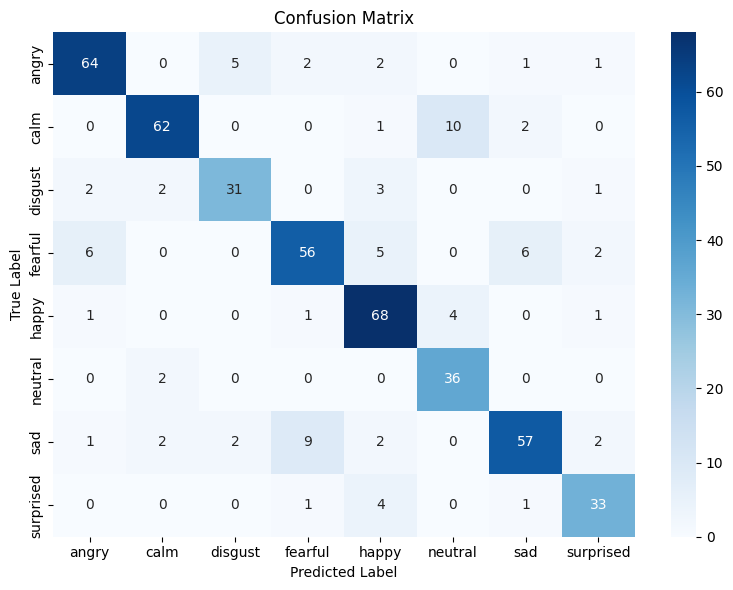

Accuracy for class 'angry': 0.85
Accuracy for class 'calm': 0.83
Accuracy for class 'disgust': 0.79
Accuracy for class 'fearful': 0.75
Accuracy for class 'happy': 0.91
Accuracy for class 'neutral': 0.95
Accuracy for class 'sad': 0.76
Accuracy for class 'surprised': 0.85


In [33]:
#10. Compute and Plot the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

#11. Compute Per-Class Accuracy

per_class_acc = cm.diagonal() / cm.sum(axis=1)

for i, acc in enumerate(per_class_acc):
    print(f"Accuracy for class '{le.classes_[i]}': {acc:.2f}")